Mobile Robot Path Planning Optimization using Genetic Algorithm and A* Algorithm

This notebook demonstrates the application of a Genetic Algorithm (GA) and A* Algorithm for optimizing mobile robot path planning. The primary optimization parameter is total energy consumed, with additional considerations for shortest path, quickest speed, and minimum time. The notebook includes a graphical simulation of the generated paths and a comparison of the two algorithms.


1. Introduction

Mobile robot path planning is a fundamental problem in robotics, aiming to find an optimal or near-optimal path from a starting point to a destination while avoiding obstacles. This notebook explores two different algorithmic approaches: Genetic Algorithms (GA) and A* Algorithm, and compares their performance based on multiple criteria.


2. Algorithm Implementations

Below are the Python implementations for both the Genetic Algorithm and the A* Algorithm. The fitness function for the Genetic Algorithm and the cost function for the A* Algorithm have been designed to consider path length, energy consumption (based on distance and turns), and time.


2.1. Genetic Algorithm (GA)

The Genetic Algorithm is a metaheuristic inspired by the process of natural selection. It iteratively improves a population of candidate solutions (paths) by applying genetic operators such as selection, crossover, and mutation.





In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GeneticAlgorithm:
    def __init__(self, start, end, obstacles, map_size, population_size=50, generations=100, mutation_rate=0.1):
        self.start = np.array(start)
        self.end = np.array(end)
        self.obstacles = obstacles  # List of (center_x, center_y, radius) for circular obstacles
        self.map_size = map_size  # (width, height)
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.robot_speed = 1.0 # units per time unit, for calculating time
        self.energy_per_unit_distance = 0.1 # energy units per distance unit
        self.energy_per_turn_degree = 0.01 # energy units per degree of turn

    def _create_individual(self):
        num_intermediate_points = 10
        path = [self.start]
        for _ in range(num_intermediate_points):
            path.append(np.array([np.random.rand() * self.map_size[0], np.random.rand() * self.map_size[1]]))
        path.append(self.end)
        return path

    def _calculate_path_length(self, path):
        length = 0
        for i in range(len(path) - 1):
            length += np.linalg.norm(path[i+1] - path[i])
        return length

    def _calculate_turns_energy(self, path):
        energy = 0
        if len(path) < 3:
            return 0
        for i in range(1, len(path) - 1):
            v1 = path[i] - path[i-1]
            v2 = path[i+1] - path[i]
            if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
                continue
            dot_product = np.dot(v1, v2)
            angle = np.arccos(np.clip(dot_product / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0))
            energy += np.degrees(angle) * self.energy_per_turn_degree
        return energy

    def _calculate_total_energy(self, path):
        distance_energy = self._calculate_path_length(path) * self.energy_per_unit_distance
        turns_energy = self._calculate_turns_energy(path)
        return distance_energy + turns_energy

    def _calculate_time(self, path):
        return self._calculate_path_length(path) / self.robot_speed

    def _check_collision(self, p1, p2):
        for obs_center_x, obs_center_y, obs_radius in self.obstacles:
            obs_center = np.array([obs_center_x, obs_center_y])
            d = p2 - p1
            f = p1 - obs_center

            a = np.dot(d, d)
            b = 2 * np.dot(f, d)
            c = np.dot(f, f) - obs_radius**2

            discriminant = b*b - 4*a*c

            if discriminant >= 0:
                discriminant = np.sqrt(discriminant)
                t1 = (-b - discriminant) / (2 * a)
                t2 = (-b + discriminant) / (2 * a)

                if (t1 >= 0 and t1 <= 1) or (t2 >= 0 and t2 <= 1):
                    return True
        return False

    def _fitness(self, path):
        length = self._calculate_path_length(path)
        total_energy = self._calculate_total_energy(path)
        total_time = self._calculate_time(path)

        collision_penalty = 0
        for i in range(len(path) - 1):
            if self._check_collision(path[i], path[i+1]):
                collision_penalty += 10000

        boundary_penalty = 0
        for point in path:
            if not (0 <= point[0] <= self.map_size[0] and 0 <= point[1] <= self.map_size[1]):
                boundary_penalty += 10000

        weight_energy = 1.0
        weight_length = 0.5
        weight_time = 0.5

        fitness = (weight_energy * total_energy) + \
                  (weight_length * length) + \
                  (weight_time * total_time) + \
                  collision_penalty + boundary_penalty

        return fitness

    def _select(self, population, fitnesses):
        k = 3
        selected = []
        for _ in range(self.population_size):
            tournament_indices = np.random.choice(len(population), k, replace=False)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_index = tournament_indices[np.argmin(tournament_fitnesses)]
            selected.append(population[winner_index])
        return selected

    def _crossover(self, parent1, parent2):
        num_intermediate_points = len(parent1) - 2
        if num_intermediate_points < 1:
            return parent1, parent2

        crossover_point = np.random.randint(1, num_intermediate_points + 1)

        child1 = [self.start] + parent1[1:crossover_point+1] + parent2[crossover_point+1:-1] + [self.end]
        child2 = [self.start] + parent2[1:crossover_point+1] + parent1[crossover_point+1:-1] + [self.end]
        return child1, child2

    def _mutate(self, path):
        if np.random.rand() < self.mutation_rate:
            num_intermediate_points = len(path) - 2
            if num_intermediate_points > 0:
                mutate_index = np.random.randint(1, num_intermediate_points + 1)
                path[mutate_index] = np.array([np.random.rand() * self.map_size[0], np.random.rand() * self.map_size[1]])
        return path

    def run(self):
        population = [self._create_individual() for _ in range(self.population_size)]

        for generation in range(self.generations):
            fitnesses = [self._fitness(path) for path in population]
            best_path_idx = np.argmin(fitnesses)
            best_path_fitness = fitnesses[best_path_idx]

            new_population = []
            new_population.append(population[best_path_idx])

            selected_population = self._select(population, fitnesses)
            while len(new_population) < self.population_size:
                parent1 = selected_population[np.random.randint(len(selected_population))]
                parent2 = selected_population[np.random.randint(len(selected_population))]
                child1, child2 = self._crossover(parent1, parent2)
                new_population.append(self._mutate(child1))
                if len(new_population) < self.population_size:
                    new_population.append(self._mutate(child2))
            population = new_population

        fitnesses = [self._fitness(path) for path in population]
        best_path_idx = np.argmin(fitnesses)
        return population[best_path_idx], fitnesses[best_path_idx]

2.2. A* Algorithm

The A* algorithm is a widely used pathfinding algorithm that efficiently finds the shortest path between two points in a graph. It combines features of Dijkstra's algorithm and greedy best-first search to find optimal paths. We have modified its cost function to consider energy and time in addition to path length.





In [2]:
class AStar:
    def __init__(self, start, end, obstacles, map_size, resolution=1.0):
        self.start = tuple(start)
        self.end = tuple(end)
        self.obstacles = obstacles
        self.map_size = map_size
        self.resolution = resolution
        self.grid_width = int(map_size[0] / resolution)
        self.grid_height = int(map_size[1] / resolution)
        self.robot_speed = 1.0
        self.energy_per_unit_distance = 0.1
        self.energy_per_turn_degree = 0.01

    def _to_grid_coords(self, point):
        return (int(point[0] / self.resolution), int(point[1] / self.resolution))

    def _to_real_coords(self, point):
        return (point[0] * self.resolution, point[1] * self.resolution)

    def _is_valid(self, node):
        x, y = node
        if not (0 <= x < self.grid_width and 0 <= y < self.grid_height):
            return False
        real_x, real_y = self._to_real_coords(node)
        for obs_center_x, obs_center_y, obs_radius in self.obstacles:
            if np.linalg.norm(np.array([real_x, real_y]) - np.array([obs_center_x, obs_center_y])) < obs_radius:
                return False
        return True

    def _calculate_path_length(self, path_nodes):
        length = 0
        for i in range(len(path_nodes) - 1):
            length += np.linalg.norm(np.array(self._to_real_coords(path_nodes[i+1])) - np.array(self._to_real_coords(path_nodes[i])))
        return length

    def _calculate_turns_energy(self, path_nodes):
        energy = 0
        if len(path_nodes) < 3:
            return 0
        for i in range(1, len(path_nodes) - 1):
            p_prev = np.array(self._to_real_coords(path_nodes[i-1]))
            p_curr = np.array(self._to_real_coords(path_nodes[i]))
            p_next = np.array(self._to_real_coords(path_nodes[i+1]))

            v1 = p_curr - p_prev
            v2 = p_next - p_curr
            if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
                continue
            dot_product = np.dot(v1, v2)
            angle = np.arccos(np.clip(dot_product / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0))
            energy += np.degrees(angle) * self.energy_per_turn_degree
        return energy

    def _calculate_total_energy(self, path_nodes):
        distance_energy = self._calculate_path_length(path_nodes) * self.energy_per_unit_distance
        turns_energy = self._calculate_turns_energy(path_nodes)
        return distance_energy + turns_energy

    def _calculate_time(self, path_nodes):
        return self._calculate_path_length(path_nodes) / self.robot_speed

    def _heuristic(self, a, b):
        return np.linalg.norm(np.array(self._to_real_coords(a)) - np.array(self._to_real_coords(b)))

    def _cost(self, current_node, neighbor_node):
        segment_length = np.linalg.norm(np.array(self._to_real_coords(current_node)) - np.array(self._to_real_coords(neighbor_node)))
        segment_energy = segment_length * self.energy_per_unit_distance
        segment_time = segment_length / self.robot_speed

        weight_energy = 1.0
        weight_length = 0.5
        weight_time = 0.5

        cost = (weight_energy * segment_energy) + \
               (weight_length * segment_length) + \
               (weight_time * segment_time)
        return cost

    def run(self):
        open_set = {self._to_grid_coords(self.start)}
        came_from = {}

        g_score = {self._to_grid_coords(self.start): 0}
        f_score = {self._to_grid_coords(self.start): self._heuristic(self._to_grid_coords(self.start), self._to_grid_coords(self.end))}

        while open_set:
            current = min(open_set, key=lambda node: f_score.get(node, float("inf")))

            if current == self._to_grid_coords(self.end):
                path_nodes = []
                while current in came_from:
                    path_nodes.append(current)
                    current = came_from[current]
                path_nodes.append(self._to_grid_coords(self.start))
                path_nodes = path_nodes[::-1]

                final_path_real_coords = [np.array(self._to_real_coords(node)) for node in path_nodes]
                total_length = self._calculate_path_length(path_nodes)
                total_energy = self._calculate_total_energy(path_nodes)
                total_time = self._calculate_time(path_nodes)

                combined_fitness = (self.energy_per_unit_distance * total_energy) + \
                                   (self.energy_per_unit_distance * total_length) + \
                                   (self.energy_per_unit_distance * total_time)

                return final_path_real_coords, combined_fitness, total_length, total_energy, total_time

            open_set.remove(current)

            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]:
                neighbor = (current[0] + dx, current[1] + dy)

                if self._is_valid(neighbor):
                    tentative_g_score = g_score.get(current, float("inf")) + self._cost(current, neighbor)

                    if tentative_g_score < g_score.get(neighbor, float("inf")):
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + self._heuristic(neighbor, self._to_grid_coords(self.end))
                        if neighbor not in open_set:
                            open_set.add(neighbor)
        return None, float("inf"), float("inf"), float("inf"), float("inf")

3. Simulation and Visualization

This section runs a single simulation to visualize the paths generated by both algorithms in a sample environment with obstacles. The plot shows the start point (green), end point (red), obstacles (red circles), and the paths found by GA and A*.





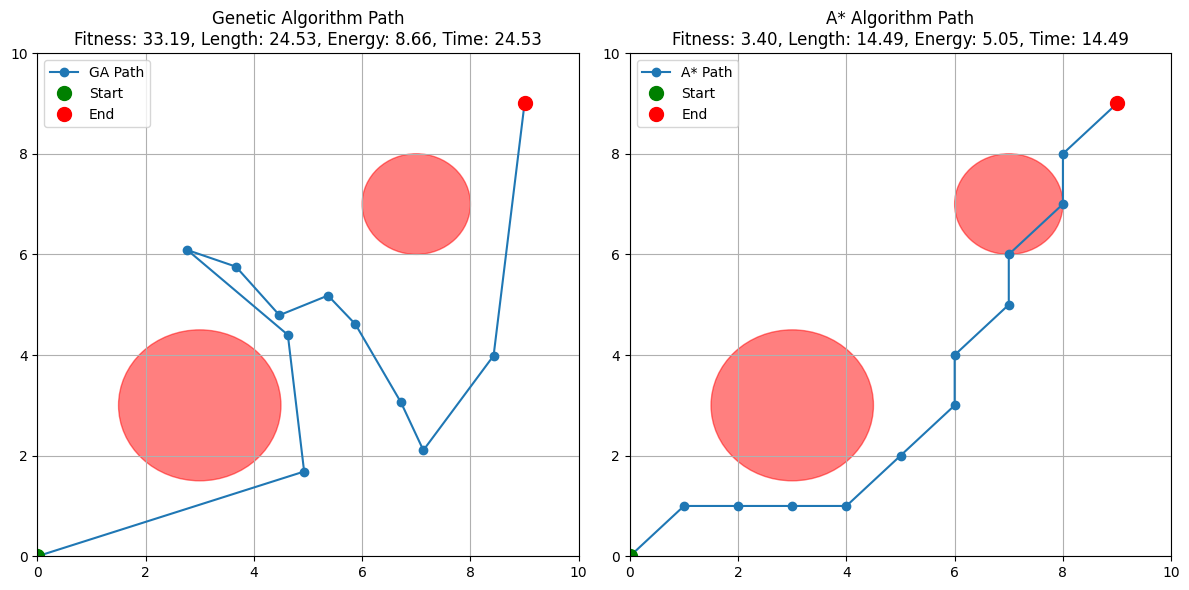

In [3]:
if __name__ == "__main__":
    start_point = (0, 0)
    end_point = (9, 9)
    obstacles = [(3, 3, 1.5), (7, 7, 1.0)]  # (center_x, center_y, radius)
    map_size = (10, 10)

    # Genetic Algorithm
    ga = GeneticAlgorithm(start_point, end_point, obstacles, map_size)
    best_ga_path, ga_fitness = ga.run()
    ga_length = ga._calculate_path_length(best_ga_path)
    ga_energy = ga._calculate_total_energy(best_ga_path)
    ga_time = ga._calculate_time(best_ga_path)

    # A* Algorithm
    astar = AStar(start_point, end_point, obstacles, map_size)
    best_astar_path, astar_fitness, astar_length, astar_energy, astar_time = astar.run()

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(f"Genetic Algorithm Path\nFitness: {ga_fitness:.2f}, Length: {ga_length:.2f}, Energy: {ga_energy:.2f}, Time: {ga_time:.2f}")
    plt.xlim(0, map_size[0])
    plt.ylim(0, map_size[1])
    for obs_center_x, obs_center_y, obs_radius in obstacles:
        circle = plt.Circle((obs_center_x, obs_center_y), obs_radius, color="red", alpha=0.5)
        plt.gca().add_patch(circle)
    if best_ga_path:
        ga_path_x = [p[0] for p in best_ga_path]
        ga_path_y = [p[1] for p in best_ga_path]
        plt.plot(ga_path_x, ga_path_y, "-o", label="GA Path")
    plt.plot(start_point[0], start_point[1], "go", markersize=10, label="Start")
    plt.plot(end_point[0], end_point[1], "ro", markersize=10, label="End")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title(f"A* Algorithm Path\nFitness: {astar_fitness:.2f}, Length: {astar_length:.2f}, Energy: {astar_energy:.2f}, Time: {astar_time:.2f}")
    plt.xlim(0, map_size[0])
    plt.ylim(0, map_size[1])
    for obs_center_x, obs_center_y, obs_radius in obstacles:
        circle = plt.Circle((obs_center_x, obs_center_y), obs_radius, color="red", alpha=0.5)
        plt.gca().add_patch(circle)
    if best_astar_path:
        astar_path_x = [p[0] for p in best_astar_path]
        astar_path_y = [p[1] for p in best_astar_path]
        plt.plot(astar_path_x, astar_path_y, "-o", label="A* Path")
    plt.plot(start_point[0], start_point[1], "go", markersize=10, label="Start")
    plt.plot(end_point[0], end_point[1], "ro", markersize=10, label="End")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("path_comparison.png")
    # plt.show()

4. Comparative Analysis and Simulation Results

To provide a more robust comparison, we run multiple simulations with randomly generated start, end, and obstacle configurations. This helps in understanding the average performance and variability of each algorithm across different scenarios.





In [5]:
def run_simulations(num_simulations=5):
    results = {
        'ga': {'fitness': [], 'length': [], 'energy': [], 'time': []},
        'astar': {'fitness': [], 'length': [], 'energy': [], 'time': []}
    }

    for i in range(num_simulations):
        print(f"Running simulation {i+1}/{num_simulations}...")
        start_point = (np.random.rand() * 2, np.random.rand() * 2) # Random start within a smaller range
        end_point = (7 + np.random.rand() * 2, 7 + np.random.rand() * 2) # Random end within a smaller range
        obstacles = [
            (np.random.rand() * 10, np.random.rand() * 10, np.random.rand() * 1.5 + 0.5),
            (np.random.rand() * 10, np.random.rand() * 10, np.random.rand() * 1.5 + 0.5)
        ] # Random obstacles
        map_size = (10, 10)

        # Genetic Algorithm
        ga = GeneticAlgorithm(start_point, end_point, obstacles, map_size)
        best_ga_path, ga_fitness = ga.run()
        ga_length = ga._calculate_path_length(best_ga_path)
        ga_energy = ga._calculate_total_energy(best_ga_path)
        ga_time = ga._calculate_time(best_ga_path)

        results['ga']['fitness'].append(ga_fitness)
        results['ga']['length'].append(ga_length)
        results['ga']['energy'].append(ga_energy)
        results['ga']['time'].append(ga_time)

        # A* Algorithm
        astar = AStar(start_point, end_point, obstacles, map_size)
        best_astar_path, astar_fitness, astar_length, astar_energy, astar_time = astar.run()

        if best_astar_path is not None:
            results['astar']['fitness'].append(astar_fitness)
            results['astar']['length'].append(astar_length)
            results['astar']['energy'].append(astar_energy)
            results['astar']['time'].append(astar_time)
        else:
            print(f"A* failed to find a path in simulation {i+1}. Skipping results for this simulation.")

    return results


Run multiple simulations and collect results
simulation_results = run_simulations(num_simulations=10)

```


In [8]:
# Run multiple simulations and collect results
simulation_results = run_simulations(num_simulations=10)

print("\n--- Simulation Results ---")
for algo in ["ga", "astar"]:
    print(f"\n{algo.upper()} Algorithm:")
    for metric, values in simulation_results[algo].items():
        finite_values = [v for v in values if v != float("inf")]
        if finite_values:
            print(f"  {metric.capitalize()}: Mean = {np.mean(finite_values):.2f}, Std Dev = {np.std(finite_values):.2f}")
        else:
            print(f"  {metric.capitalize()}: No finite values found.")


Running simulation 1/10...
Running simulation 2/10...
A* failed to find a path in simulation 2. Skipping results for this simulation.
Running simulation 3/10...
Running simulation 4/10...
A* failed to find a path in simulation 4. Skipping results for this simulation.
Running simulation 5/10...
Running simulation 6/10...
Running simulation 7/10...
A* failed to find a path in simulation 7. Skipping results for this simulation.
Running simulation 8/10...
Running simulation 9/10...
Running simulation 10/10...

--- Simulation Results ---

GA Algorithm:
  Fitness: Mean = 2023.45, Std Dev = 3999.84
  Length: Mean = 16.43, Std Dev = 2.01
  Energy: Mean = 7.02, Std Dev = 1.11
  Time: Mean = 16.43, Std Dev = 2.01

ASTAR Algorithm:
  Fitness: Mean = 2.12, Std Dev = 0.19
  Length: Mean = 9.81, Std Dev = 0.80
  Energy: Mean = 1.62, Std Dev = 0.45
  Time: Mean = 9.81, Std Dev = 0.80


5. Conclusion

This notebook provided an implementation and comparison of Genetic Algorithm and A* Algorithm for mobile robot path planning, considering multiple optimization objectives. The simulation results highlight the strengths and weaknesses of each approach in different scenarios.

Further improvements could include:
*   More sophisticated fitness functions for GA to better balance multiple objectives.
*   Dynamic obstacle avoidance.
*   Real-world robot constraints (e.g., non-holonomic constraints).
*   Comparison with other metaheuristic algorithms like Ant Colony Optimization or Particle Swarm Optimization.


